# Car Purchase Prediction Project

This notebook implements a Machine Learning classification project to predict whether a customer will buy a car based on their details.

## Objectives:
1. Load and explore the dataset.
2. Preprocess the data (handle missing values, encode categoricals, scale features).
3. Train multiple classification models (Logistic Regression, Random Forest, Decision Tree, KNN, SVM).
4. Evaluate models using Accuracy, Confusion Matrix, Classification Report, and ROC-AUC.
5. Visualize results.
6. Build a prediction system for new data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Dataset Automatically

In [2]:
def load_dataset():
    possible_names = ['car_data.csv', 'Car_Purchase.csv', 'customer_car_buy.csv', 'DigitalAd_dataset.csv']
    
    # Check specific names first
    for name in possible_names:
        if os.path.exists(name):
            print(f"✅ Feature Detected: Loading dataset from '{name}'")
            return pd.read_csv(name)
    
    # Search for any CSV file
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if len(csv_files) == 1:
        print(f"✅ Found single CSV file: '{csv_files[0]}'. Loading...")
        return pd.read_csv(csv_files[0])
    elif len(csv_files) > 1:
        print("⚠️ Multiple CSV files found:", csv_files)
        # Simple heuristic: pick the first one or ask user (in a script we'd input, in notebook we pick first for automation)
        print(f"👉 Loading the first one: '{csv_files[0]}'")
        return pd.read_csv(csv_files[0])
    else:
        raise FileNotFoundError("❌ No dataset file found in current directory!")

try:
    df = load_dataset()
    print("\n--- Dataset info ---")
    print(f"Shape: {df.shape}")
    display(df.head())
except Exception as e:
    print(e)

✅ Feature Detected: Loading dataset from 'DigitalAd_dataset.csv'

--- Dataset info ---
Shape: (400, 3)


,Age,Salary,Status
0,18,82000,0
1,29,80000,0
2,47,25000,1
3,45,26000,1
4,46,28000,1


## 2. Exploratory Data Analysis (EDA)

In [3]:
print("\n--- Basic Statistics ---")
display(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicates ---")
duplicates = df.duplicated().sum()
print(f"Total Duplicates: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print("✅ Duplicates removed.")


--- Basic Statistics ---


,Age,Salary,Status
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000



--- Missing Values ---
Age       0
Salary    0
Status    0
dtype: int64

--- Duplicates ---
Total Duplicates: 33
✅ Duplicates removed.



🎯 Target Column Detected: 'Status'


C:\Users\Asus\AppData\Local\Temp\ipykernel_14404\3861478213.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='viridis')


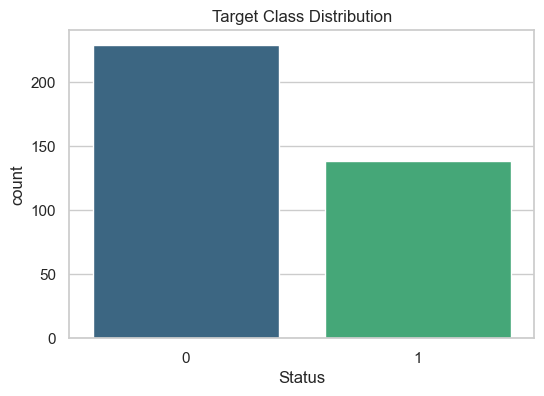

In [4]:
# Determine Target Column (assuming it is the last column or named 'Status'/'Purchased')
# Based on user description: Status or Purchased = 1/0
target_col = 'Status' if 'Status' in df.columns else df.columns[-1]
print(f"\n🎯 Target Column Detected: '{target_col}'")

# Target Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df, palette='viridis')
plt.title('Target Class Distribution')
plt.show()

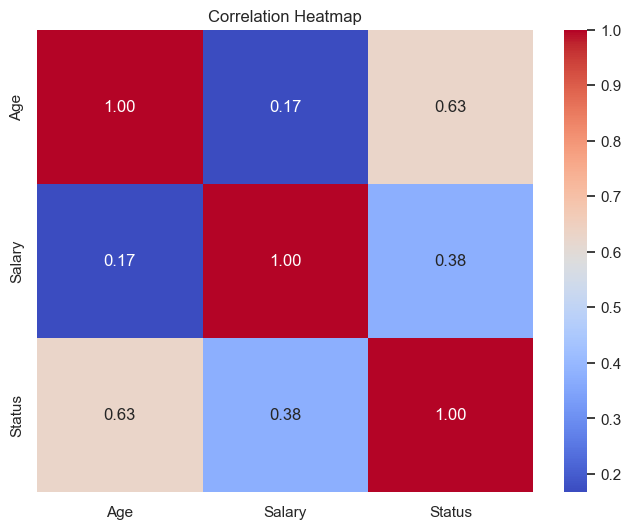

In [5]:
# Correlation Heatmap (Numerical Columns Only)
plt.figure(figsize=(8, 6))
numerical_cols = df.select_dtypes(include=['number']).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 3. Data Preprocessing

In [6]:
# Separate Features and Target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identifiy Numerical and Categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

# Define Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Preprocessing
# We fit on train and transform both
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after encoding (for importance plot later)
if categorical_cols:
    cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([numerical_cols, cat_feature_names])
else:
    feature_names = numerical_cols

print("\n✅ Data Preprocessing Complete.")
print(f"Train shape: {X_train_processed.shape}, Test shape: {X_test_processed.shape}")

Numerical Columns: ['Age', 'Salary']
Categorical Columns: []

✅ Data Preprocessing Complete.
Train shape: (293, 2), Test shape: (74, 2)


## 4. Model Training & Evaluation

In [7]:
# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
best_model = None
best_score = 0
best_model_name = ""

print("TRAINING RESULTS:\n")

for name, model in models.items():
    # Train
    model.fit(X_train_processed, y_train)
    
    # Predict
    y_pred = model.predict(X_test_processed)
    try:
        y_proba = model.predict_proba(X_test_processed)[:, 1]
    except:
        y_proba = [0]*len(y_test) # Handle cases where proba might not be available directly

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0
    
    results[name] = {'Accuracy': acc, 'ROC_AUC': roc, 'Model': model}
    
    print(f"🔹 {name} -> Accuracy: {acc:.4f} | ROC AUC: {roc:.4f}")
    
    # Save best model
    if acc > best_score:
        best_score = acc
        best_model = model
        best_model_name = name

print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {best_score:.4f}")

TRAINING RESULTS:

🔹 Logistic Regression -> Accuracy: 0.7703 | ROC AUC: 0.8890
🔹 Random Forest -> Accuracy: 0.8514 | ROC AUC: 0.8706
🔹 Decision Tree -> Accuracy: 0.8514 | ROC AUC: 0.8094
🔹 KNN -> Accuracy: 0.8649 | ROC AUC: 0.8571
🔹 SVM -> Accuracy: 0.8784 | ROC AUC: 0.9061

🏆 Best Model: SVM with Accuracy: 0.8784


## 5. Visualizations & Comprehensive Reporting

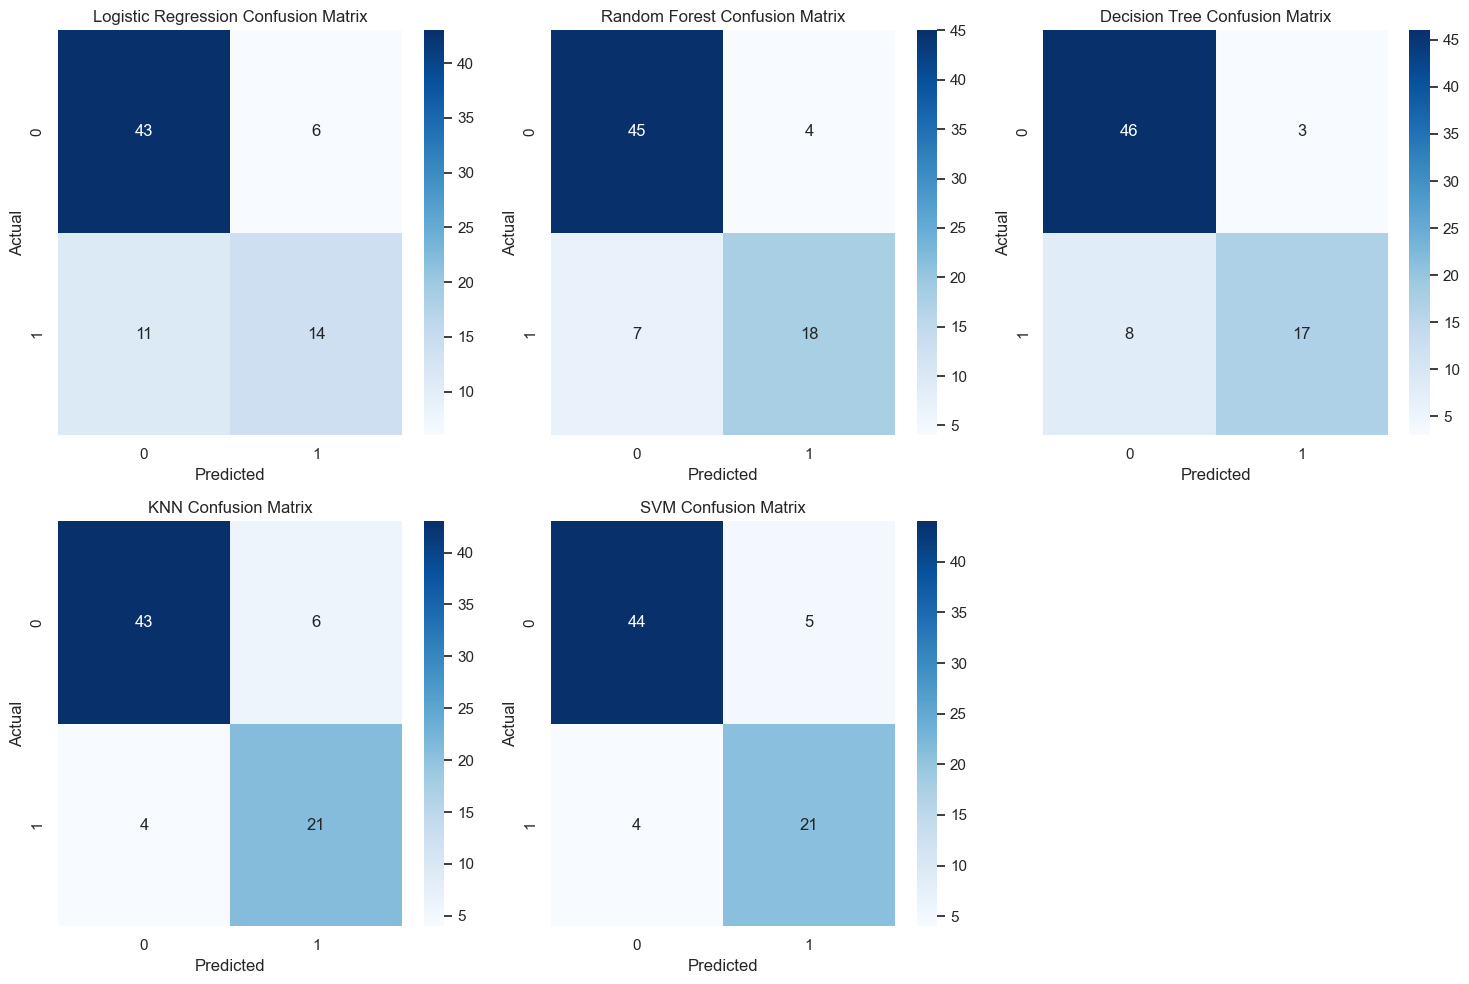

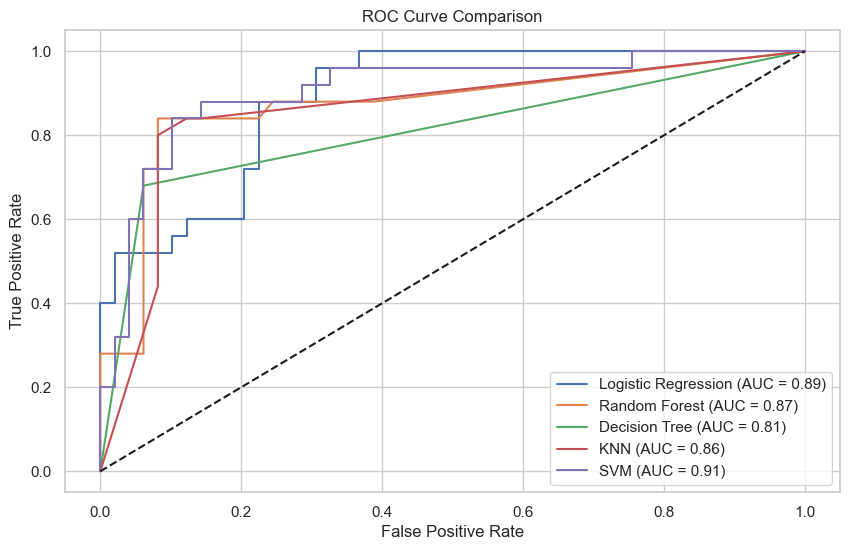

In [8]:
# 1. Confusion Matrices Comparison
plt.figure(figsize=(15, 10))
for i, (name, info) in enumerate(results.items()):
    model = info['Model']
    y_pred = model.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 2. ROC Curve Comparison
plt.figure(figsize=(10, 6))
for name, info in results.items():
    model = info['Model']
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {info['ROC_AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_14404\3336083732.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis')


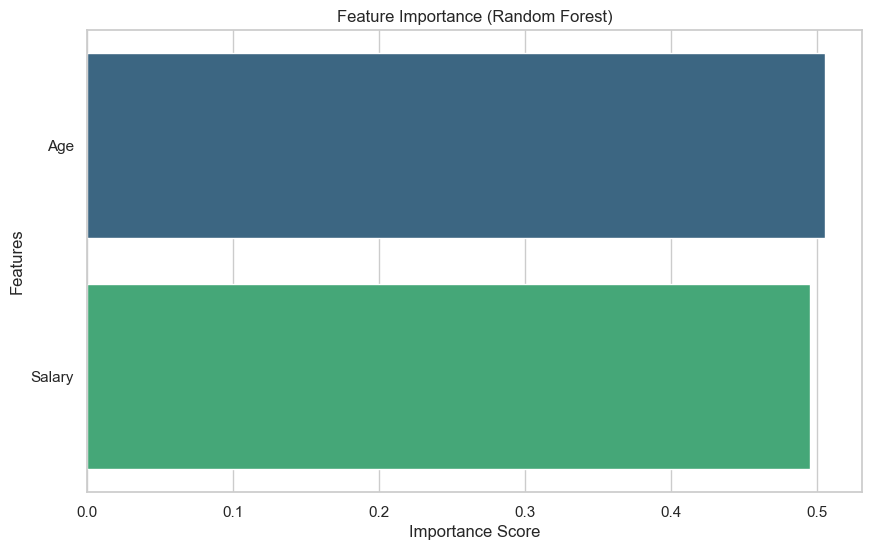

In [9]:
# 3. Feature Importance (Random Forest)
if "Random Forest" in results:
    rf_model = results["Random Forest"]['Model']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis')
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

In [10]:
# 4. Classification Report for Best Model
print(f"--- Classification Report for {best_model_name} ---")
y_pred_best = best_model.predict(X_test_processed)
print(classification_report(y_test, y_pred_best))

# Save the Model and Preprocessor
joblib.dump(best_model, 'best_car_purchase_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("✅ Best model and preprocessor saved successfully!")

--- Classification Report for SVM ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        49
           1       0.81      0.84      0.82        25

    accuracy                           0.88        74
   macro avg       0.86      0.87      0.87        74
weighted avg       0.88      0.88      0.88        74

✅ Best model and preprocessor saved successfully!


## 6. Prediction System

In [12]:
def predict_purchase():
    print("\n--- Predict Customer Purchase ---")
    try:
        # Get numerical inputs
        input_data = {}
        for col in numerical_cols:
            val = float(input(f"Enter {col}: "))
            input_data[col] = [val]
            
        # Get categorical inputs (if any)
        for col in categorical_cols:
            val = input(f"Enter {col}: ")
            input_data[col] = [val]

        # Create DataFrame
        input_df = pd.DataFrame(input_data)
        
        # Transform
        processed_data = preprocessor.transform(input_df)
        
        # Predict
        prediction = best_model.predict(processed_data)[0]
        probability = best_model.predict_proba(processed_data)[0][1]
        
        print("\n---------------------------------")
        if prediction == 1:
            print(f"✅ Prediction: Customer WILL buy the car! (Confidence: {probability:.2%})")
        else:
            print(f"❌ Prediction: Customer will NOT buy the car. (Confidence: {1-probability:.2%})")
        print("---------------------------------")
        
    except ValueError:
        print("⚠️ Invalid input! Please enter numbers for numerical fields.")
    except Exception as e:
        print(f"⚠️ Error during prediction: {e}")

# Uncomment the line below to run the prediction interactively in the notebook
predict_purchase()


--- Predict Customer Purchase ---

---------------------------------
❌ Prediction: Customer will NOT buy the car. (Confidence: 94.25%)
---------------------------------
